# Linear Discriminant Analysis

In [1]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
data = pd.read_table('iris.csv', sep=',')
data = shuffle(data)
data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
45,46,4.8,3.0,1.4,0.3,Iris-setosa
62,63,6.0,2.2,4.0,1.0,Iris-versicolor
103,104,6.3,2.9,5.6,1.8,Iris-virginica
20,21,5.4,3.4,1.7,0.2,Iris-setosa
69,70,5.6,2.5,3.9,1.1,Iris-versicolor


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 45 to 53
Data columns (total 6 columns):
Id               150 non-null int64
SepalLengthCm    150 non-null float64
SepalWidthCm     150 non-null float64
PetalLengthCm    150 non-null float64
PetalWidthCm     150 non-null float64
Species          150 non-null object
dtypes: float64(4), int64(1), object(1)
memory usage: 8.2+ KB


In [4]:
data.describe()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,75.500000,5.843333,3.054000,3.758667,1.198667
std,43.445368,0.828066,0.433594,1.764420,0.763161
min,1.000000,4.300000,2.000000,1.000000,0.100000
25%,38.250000,5.100000,2.800000,1.600000,0.300000
50%,75.500000,5.800000,3.000000,4.350000,1.300000
75%,112.750000,6.400000,3.300000,5.100000,1.800000
max,150.000000,7.900000,4.400000,6.900000,2.500000


In [5]:
data.loc[:, ['Species']] = data.loc[:, ['Species']].applymap(lambda x: 0 if (x=='Iris-setosa') else x)
data.loc[:, ['Species']] = data.loc[:, ['Species']].applymap(lambda x: 1 if (x=='Iris-versicolor') else x)
data.loc[:, ['Species']] = data.loc[:, ['Species']].applymap(lambda x: 2 if (x=='Iris-virginica') else x)
data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
45,46,4.8,3.0,1.4,0.3,0
62,63,6.0,2.2,4.0,1.0,1
103,104,6.3,2.9,5.6,1.8,2
20,21,5.4,3.4,1.7,0.2,0
69,70,5.6,2.5,3.9,1.1,1


In [6]:
X_train = data.iloc[:,1:5].values[:120,:]
Y_train_labels = data.iloc[:,5].values[:120]
Y_train = np.reshape(np.eye(3)[Y_train_labels],(-1,3))

X_test = data.iloc[:,1:5].values[120:,:]
Y_test_labels = data.iloc[:,5].values[120:]
Y_test = np.reshape(np.eye(3)[Y_test_labels],(-1,3))

In [7]:
class Layer1():
    
    def __init__(self, model, input_dim, output_dim):
        self.model = model
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.build()
        
    def build(self):
        self.weights = []
        self.mu = tf.zeros(shape=(1,self.output_dim), dtype="float32")
        self.sigma = tf.ones(shape=(1,self.output_dim), dtype="float32")

    def __call__(self, inputs):
        return (inputs-self.mu)/self.sigma
    
class Layer2():
    
    def __init__(self, model, input_dim, output_dim):
        self.model = model
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.build()
        
    def add_weight(self, shape):
        weight_init = tf.random.normal(shape=shape, mean=0.0, stddev=0.05, dtype="float32")
        return tf.Variable(initial_value=weight_init, trainable=True)
        
    def build(self):
        self.w = self.add_weight(shape=(self.output_dim, self.input_dim))
        self.b = self.add_weight(shape=(self.output_dim, 1))
        self.weights = [self.w, self.b]
        
    def __call__(self, inputs):
        z = tf.matmul(self.w, tf.transpose(inputs)) + self.b
        v = tf.transpose(z)
        u = tf.math.exp(v)
        return u/tf.math.reduce_sum(u, axis=1, keepdims=True)
    
class Layer3():
    
    def __init__(self, model, input_dim, output_dim):
        self.model = model
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.build()
            
    def build(self): 
        self.weights = []

    def __call__(self, inputs):
        return tf.reshape(tf.math.argmax(inputs, axis=1), shape=(-1,1))

In [8]:
class LossFunction():
        
    def __init__(self, model):
        self.model = model
            
    def __call__(self, y_true, y_pred):
        return -tf.math.reduce_mean(tf.math.reduce_mean(y_true*tf.math.log(y_pred), axis=1), axis=0)

In [9]:
class MetricFunction():
        
    def __init__(self, model):
        self.model = model
            
    def __call__(self, y_true, y_pred):
        maximum = tf.math.reduce_max(y_pred, axis=1, keepdims=True)
        y_pred_ = tf.sign(1+tf.sign(y_pred-maximum))
        return tf.math.reduce_mean(tf.math.reduce_mean(1-tf.square(tf.sign(y_true-y_pred_)), axis=1), axis=0) 

In [10]:
class Optimizer():

    def __init__(self, model, learning_rate, beta_1, beta_2, epsilon):
        self.model = model
        self.learning_rate = learning_rate
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon= epsilon
        self.stop_training = False
        self.build()
        
    def add_weight(self, shape):
        weight_init = tf.zeros(shape=shape, dtype="float32")
        return  tf.Variable(initial_value=weight_init, trainable=False)
    
    def build(self):
        self.weights = []
        for weight in self.model.weights:
            m = self.add_weight(shape=weight.shape)
            v = self.add_weight(shape=weight.shape)
            self.weights.append([m,v])
            
    def apply(self, grads, weights):
        for i in range(len(weights)):
            w = weights[i]
            grad_w = grads[i]
            m = self.weights[i][0]
            v = self.weights[i][1]
            self.weights[i][0].assign(self.beta_1*m + (1-self.beta_1)*grad_w)  
            self.weights[i][1].assign(self.beta_2*v + (1-self.beta_2)*grad_w*grad_w)
            m_ = (1/(1-self.beta_1))*self.weights[i][0]
            v_ = (1/(1-self.beta_2))*self.weights[i][1]
            weights[i].assign(w - self.learning_rate*m_/(tf.math.sqrt(v_)+self.epsilon))
            
    def train_step(self, X, Y):
        with tf.GradientTape() as tape:
            H = self.model(X)
            loss = self.model.loss(Y, H)
        grads = tape.gradient(loss, self.model.weights)
        self.apply(grads, self.model.weights)
        H = self.model(X)
        loss = self.model.loss(Y, H)
        metric = self.model.metric(Y, H)
        logs = {'loss': loss,
                'metric': metric}
        return logs

In [11]:
class Callback1():

    def __init__(self, model, verbose):
        self.model = model
        self.verbose = verbose
    
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = tf.timestamp()
        
    def on_epoch_end(self, epoch, logs=None):
        if self.verbose:
            now = tf.timestamp()
            time = now - self.start_time
            tf.print('Epochs {}/{} - Loss: {} - Metric: {}'.format(epoch+1, self.model.epochs, logs['loss'], logs['metric']))
            tf.print('----- {}s -----'.format(tf.round(1000*time)/1000))
            
class Callback2():

    def __init__(self, model):
        self.model = model
        self.history = {'loss':[],
                        'metric':[]}
        
    def on_epoch_end(self, epoch, logs):
        self.history['loss'].append(logs['loss'].numpy())
        self.history['metric'].append(logs['metric'].numpy())
        
    def on_train_end(self):
        self.model.history = self.history

class Callback3():
        
    def __init__(self, model, patience, error, reduce_factor, min_learning_rate):
        self.model = model
        self.patience = patience
        self.error = error
        self.reduce_factor = reduce_factor
        self.min_learning_rate = min_learning_rate
                        
    def on_epoch_end(self, epoch, logs):
        if epoch==0:
            self.loss = logs['loss']
            self.non_decreasing_epochs = 0
        else:
            if ((self.loss-logs['loss'])>self.error):
                self.loss = logs['loss']
                self.non_decreasing_epochs = 0
            else:
                self.non_decreasing_epochs = self.non_decreasing_epochs+1
        if (self.non_decreasing_epochs == self.patience):
            if (self.model.optimizer.learning_rate>self.min_learning_rate):
                self.model.optimizer.learning_rate = self.reduce_factor*self.model.optimizer.learning_rate
                self.non_decreasing_epochs = 0
        
class Callback4():
        
    def __init__(self, model, patience, error):
        self.model = model
        self.patience = patience
        self.error = error
        
    def on_epoch_end(self, epoch, logs):
        if epoch==0:
            self.loss = logs['loss']
            self.non_decreasing_epochs = 0
        else:
            if ((self.loss-logs['loss'])>self.error):
                self.loss = logs['loss']
                self.non_decreasing_epochs = 0
            else:
                self.non_decreasing_epochs = self.non_decreasing_epochs+1
        if (self.non_decreasing_epochs == self.patience):
            self.model.optimizer.stop_training = True

In [12]:
class LDA():
    
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.build()
    
    def build(self):
        self.h1 = Layer1(model=self, input_dim=self.input_dim, output_dim=self.output_dim)
        self.h2 = Layer2(model=self, input_dim=self.input_dim, output_dim=self.output_dim)
        self.h3 = Layer3(model=self, input_dim=self.input_dim, output_dim=self.output_dim)
        self.layers = [self.h1, self.h2, self.h3]
        self.weights = []
        for layer in self.layers:
            for weight in layer.weights:
                self.weights.append(weight)
        
    def __call__(self, inputs):
        a1 = self.h1(inputs)
        y = self.h2(a1)
        return y
        
    def train_setup(self, epochs, learning_rate, beta_1, beta_2, epsilon, verbose):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.beta_1 = beta_1 
        self.beta_2 = beta_2 
        self.epsilon = epsilon
        self.verbose = verbose
        self.loss = LossFunction(model=self)
        self.metric = MetricFunction(model=self)
        self.optimizer = Optimizer(model=self, learning_rate=self.learning_rate, beta_1=self.beta_1, beta_2=self.beta_2, epsilon=self.epsilon)
        self.callbacks = [Callback1(model=self, verbose=self.verbose),
                          Callback2(model=self),
                          Callback3(model=self, patience=1000, error=0.001, reduce_factor=0.1, min_learning_rate=0.001),
                          Callback4(model=self, patience=2000, error=0.001)]
        
    def fit(self, X, Y, epochs=10000, learning_rate=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-07, verbose=True):
        self.layers[0].mu = tf.math.reduce_mean(tf.constant(X, dtype="float32"), axis=0)
        self.layers[0].sigma = tf.math.reduce_std(tf.constant(X, dtype="float32"), axis=0)
        self.train_setup(epochs, learning_rate, beta_1, beta_2, epsilon, verbose)
        if verbose:
            print('Train on {} samples'.format(X.shape[0]))
        for epoch in range(self.epochs):
            self.callbacks[0].on_epoch_begin(epoch)
            logs = self.optimizer.train_step(tf.constant(X, dtype="float32"), tf.constant(Y, dtype="float32"))
            for callback in self.callbacks:
                callback.on_epoch_end(epoch, logs)
            if self.optimizer.stop_training:
                break
        self.callbacks[1].on_train_end()
            
    def predict(self, inputs):
        return self.h3(self(tf.constant(inputs, dtype="float32"))).numpy()
    
    def evaluate(self, X, Y):
        loss = self.loss(tf.constant(Y, dtype="float32"), self(tf.constant(X, dtype="float32")))
        loss_numpy = loss.numpy()
        metric = self.metric(tf.constant(Y, dtype="float32"), self(tf.constant(X, dtype="float32")))
        metric_numpy = metric.numpy()
        tf.print('Loss: {} - Metric: {}'.format(loss_numpy, metric_numpy))
        return [loss_numpy, metric_numpy]

In [13]:
lda = LDA(input_dim=X_train.shape[1], output_dim=Y_train.shape[1])

lda.fit(X_train, Y_train)

Train on 120 samples
Epochs 1/10000 - Loss: 0.2749832272529602 - Metric: 0.855555534362793
----- 0.051s -----
Epochs 2/10000 - Loss: 0.20961284637451172 - Metric: 0.9222222566604614
----- 0.006s -----
Epochs 3/10000 - Loss: 0.16437633335590363 - Metric: 0.8999999761581421
----- 0.004s -----
Epochs 4/10000 - Loss: 0.13604636490345 - Metric: 0.9055555462837219
----- 0.004s -----
Epochs 5/10000 - Loss: 0.11728604882955551 - Metric: 0.9277777075767517
----- 0.004s -----
Epochs 6/10000 - Loss: 0.10393581539392471 - Metric: 0.9333333373069763
----- 0.004s -----
Epochs 7/10000 - Loss: 0.09408546984195709 - Metric: 0.9333333373069763
----- 0.004s -----
Epochs 8/10000 - Loss: 0.08635871857404709 - Metric: 0.9388889074325562
----- 0.004s -----
Epochs 9/10000 - Loss: 0.07944746315479279 - Metric: 0.944444477558136
----- 0.005s -----
Epochs 10/10000 - Loss: 0.07262767851352692 - Metric: 0.949999988079071
----- 0.004s -----
Epochs 11/10000 - Loss: 0.06601487845182419 - Metric: 0.9611111283302307
--

----- 0.004s -----
Epochs 90/10000 - Loss: 0.021384481340646744 - Metric: 0.9833333492279053
----- 0.004s -----
Epochs 91/10000 - Loss: 0.02133600227534771 - Metric: 0.9833333492279053
----- 0.005s -----
Epochs 92/10000 - Loss: 0.021288160234689713 - Metric: 0.9833333492279053
----- 0.005s -----
Epochs 93/10000 - Loss: 0.021240929141640663 - Metric: 0.9833333492279053
----- 0.004s -----
Epochs 94/10000 - Loss: 0.021194282919168472 - Metric: 0.9833333492279053
----- 0.004s -----
Epochs 95/10000 - Loss: 0.021148204803466797 - Metric: 0.9833333492279053
----- 0.004s -----
Epochs 96/10000 - Loss: 0.02110268361866474 - Metric: 0.9833333492279053
----- 0.004s -----
Epochs 97/10000 - Loss: 0.021057704463601112 - Metric: 0.9833333492279053
----- 0.004s -----
Epochs 98/10000 - Loss: 0.02101326733827591 - Metric: 0.9833333492279053
----- 0.004s -----
Epochs 99/10000 - Loss: 0.020969361066818237 - Metric: 0.9833333492279053
----- 0.004s -----
Epochs 100/10000 - Loss: 0.020925968885421753 - Metric

----- 0.004s -----
Epochs 178/10000 - Loss: 0.01858328841626644 - Metric: 0.9833333492279053
----- 0.004s -----
Epochs 179/10000 - Loss: 0.018562236800789833 - Metric: 0.9833333492279053
----- 0.004s -----
Epochs 180/10000 - Loss: 0.018541347235441208 - Metric: 0.9833333492279053
----- 0.004s -----
Epochs 181/10000 - Loss: 0.01852061040699482 - Metric: 0.9833333492279053
----- 0.004s -----
Epochs 182/10000 - Loss: 0.01850002259016037 - Metric: 0.9833333492279053
----- 0.005s -----
Epochs 183/10000 - Loss: 0.01847958378493786 - Metric: 0.9833333492279053
----- 0.004s -----
Epochs 184/10000 - Loss: 0.018459297716617584 - Metric: 0.9833333492279053
----- 0.004s -----
Epochs 185/10000 - Loss: 0.01843915693461895 - Metric: 0.9833333492279053
----- 0.004s -----
Epochs 186/10000 - Loss: 0.018419163301587105 - Metric: 0.9833333492279053
----- 0.004s -----
Epochs 187/10000 - Loss: 0.018399309366941452 - Metric: 0.9833333492279053
----- 0.004s -----
Epochs 188/10000 - Loss: 0.01837960071861744 -

----- 0.004s -----
Epochs 266/10000 - Loss: 0.017180467024445534 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 267/10000 - Loss: 0.017168449237942696 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 268/10000 - Loss: 0.01715649478137493 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 269/10000 - Loss: 0.01714460924267769 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 270/10000 - Loss: 0.01713278703391552 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 271/10000 - Loss: 0.017121028155088425 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 272/10000 - Loss: 0.017109336331486702 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 273/10000 - Loss: 0.017097704112529755 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 274/10000 - Loss: 0.017086131498217583 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 275/10000 - Loss: 0.017074627801775932 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 276/10000 - Loss: 0.01706318184733390

----- 0.005s -----
Epochs 354/10000 - Loss: 0.016326816752552986 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 355/10000 - Loss: 0.0163190308958292 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 356/10000 - Loss: 0.016311269253492355 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 357/10000 - Loss: 0.016303546726703644 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 358/10000 - Loss: 0.016295859590172768 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 359/10000 - Loss: 0.01628820411860943 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 360/10000 - Loss: 0.016280584037303925 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 361/10000 - Loss: 0.016272995620965958 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 362/10000 - Loss: 0.016265440732240677 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 363/10000 - Loss: 0.016257919371128082 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 364/10000 - Loss: 0.01625042781233787

----- 0.004s -----
Epochs 442/10000 - Loss: 0.01575212925672531 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 443/10000 - Loss: 0.01574668101966381 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 444/10000 - Loss: 0.015741251409053802 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 445/10000 - Loss: 0.015735847875475883 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 446/10000 - Loss: 0.01573045365512371 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 447/10000 - Loss: 0.015725089237093925 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 448/10000 - Loss: 0.015719741582870483 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 449/10000 - Loss: 0.015714412555098534 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 450/10000 - Loss: 0.015709102153778076 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 451/10000 - Loss: 0.01570381410419941 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 452/10000 - Loss: 0.015698546543717384

----- 0.004s -----
Epochs 530/10000 - Loss: 0.015340032987296581 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 531/10000 - Loss: 0.015336026437580585 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 532/10000 - Loss: 0.01533203013241291 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 533/10000 - Loss: 0.015328050591051579 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 534/10000 - Loss: 0.015324084088206291 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 535/10000 - Loss: 0.015320124104619026 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 536/10000 - Loss: 0.015316185541450977 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 537/10000 - Loss: 0.015312252566218376 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 538/10000 - Loss: 0.01530833262950182 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 539/10000 - Loss: 0.01530443225055933 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 540/10000 - Loss: 0.01530053839087486

----- 0.004s -----
Epochs 618/10000 - Loss: 0.015031465329229832 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 619/10000 - Loss: 0.015028410591185093 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 620/10000 - Loss: 0.0150253651663661 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 621/10000 - Loss: 0.015022323466837406 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 622/10000 - Loss: 0.015019296668469906 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 623/10000 - Loss: 0.015016275458037853 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 624/10000 - Loss: 0.015013262629508972 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 625/10000 - Loss: 0.015010260976850986 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 626/10000 - Loss: 0.015007265843451023 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 627/10000 - Loss: 0.015004278160631657 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 628/10000 - Loss: 0.0150013053789734

----- 0.004s -----
Epochs 706/10000 - Loss: 0.014793036505579948 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 707/10000 - Loss: 0.014790638349950314 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 708/10000 - Loss: 0.014788256026804447 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 709/10000 - Loss: 0.01478587370365858 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 710/10000 - Loss: 0.014783497899770737 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 711/10000 - Loss: 0.014781130477786064 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 712/10000 - Loss: 0.01477876864373684 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 713/10000 - Loss: 0.014776412397623062 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 714/10000 - Loss: 0.014774066396057606 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 715/10000 - Loss: 0.014771721325814724 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 716/10000 - Loss: 0.0147693809121847

----- 0.004s -----
Epochs 794/10000 - Loss: 0.014604372903704643 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 795/10000 - Loss: 0.014602459035813808 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 796/10000 - Loss: 0.014600548893213272 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 797/10000 - Loss: 0.014598647132515907 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 798/10000 - Loss: 0.014596746303141117 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 799/10000 - Loss: 0.014594847336411476 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 800/10000 - Loss: 0.01459296140819788 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 801/10000 - Loss: 0.014591071754693985 - Metric: 0.9888889193534851
----- 0.006s -----
Epochs 802/10000 - Loss: 0.014589190483093262 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 803/10000 - Loss: 0.014587314799427986 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 804/10000 - Loss: 0.014585443772375

----- 0.004s -----
Epochs 882/10000 - Loss: 0.014452304691076279 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 883/10000 - Loss: 0.014450746588408947 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 884/10000 - Loss: 0.014449198730289936 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 885/10000 - Loss: 0.014447647146880627 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 886/10000 - Loss: 0.014446101151406765 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 887/10000 - Loss: 0.014444560743868351 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 888/10000 - Loss: 0.014443024061620235 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 889/10000 - Loss: 0.014441492035984993 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 890/10000 - Loss: 0.014439960941672325 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 891/10000 - Loss: 0.014438432641327381 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 892/10000 - Loss: 0.01443691086024

----- 0.006s -----
Epochs 970/10000 - Loss: 0.014327921904623508 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 971/10000 - Loss: 0.014326642267405987 - Metric: 0.9888889193534851
----- 0.007s -----
Epochs 972/10000 - Loss: 0.01432536169886589 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 973/10000 - Loss: 0.014324088580906391 - Metric: 0.9888889193534851
----- 0.006s -----
Epochs 974/10000 - Loss: 0.014322813600301743 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 975/10000 - Loss: 0.014321548864245415 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 976/10000 - Loss: 0.01432027854025364 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 977/10000 - Loss: 0.01431901566684246 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 978/10000 - Loss: 0.014317754656076431 - Metric: 0.9888889193534851
----- 0.007s -----
Epochs 979/10000 - Loss: 0.0143164973706007 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 980/10000 - Loss: 0.014315239153802395 

----- 0.008s -----
Epochs 1057/10000 - Loss: 0.01422603614628315 - Metric: 0.9888889193534851
----- 0.008s -----
Epochs 1058/10000 - Loss: 0.014224969781935215 - Metric: 0.9888889193534851
----- 0.006s -----
Epochs 1059/10000 - Loss: 0.014223902486264706 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 1060/10000 - Loss: 0.014222842641174793 - Metric: 0.9888889193534851
----- 0.006s -----
Epochs 1061/10000 - Loss: 0.014221783727407455 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 1062/10000 - Loss: 0.014220725744962692 - Metric: 0.9888889193534851
----- 0.006s -----
Epochs 1063/10000 - Loss: 0.01421966589987278 - Metric: 0.9888889193534851
----- 0.007s -----
Epochs 1064/10000 - Loss: 0.014218613505363464 - Metric: 0.9888889193534851
----- 0.007s -----
Epochs 1065/10000 - Loss: 0.014217558316886425 - Metric: 0.9888889193534851
----- 0.016s -----
Epochs 1066/10000 - Loss: 0.014216508716344833 - Metric: 0.9888889193534851
----- 0.018s -----
Epochs 1067/10000 - Loss: 0.01421

----- 0.005s -----
Epochs 1144/10000 - Loss: 0.014140725135803223 - Metric: 0.9888889193534851
----- 0.006s -----
Epochs 1145/10000 - Loss: 0.014139827340841293 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 1146/10000 - Loss: 0.014138931408524513 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 1147/10000 - Loss: 0.014138037338852882 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 1148/10000 - Loss: 0.014137142337858677 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 1149/10000 - Loss: 0.014136253856122494 - Metric: 0.9888889193534851
----- 0.006s -----
Epochs 1150/10000 - Loss: 0.014135362580418587 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 1151/10000 - Loss: 0.014134475961327553 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 1152/10000 - Loss: 0.014133591204881668 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 1153/10000 - Loss: 0.014132707379758358 - Metric: 0.9888889193534851
----- 0.006s -----
Epochs 1154/10000 - Loss: 0.014

----- 0.004s -----
Epochs 1231/10000 - Loss: 0.014068719930946827 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 1232/10000 - Loss: 0.014067957177758217 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 1233/10000 - Loss: 0.014067192561924458 - Metric: 0.9888889193534851
----- 0.006s -----
Epochs 1234/10000 - Loss: 0.014066439121961594 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 1235/10000 - Loss: 0.014065684750676155 - Metric: 0.9888889193534851
----- 0.006s -----
Epochs 1236/10000 - Loss: 0.014064925722777843 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 1237/10000 - Loss: 0.014064175076782703 - Metric: 0.9888889193534851
----- 0.006s -----
Epochs 1238/10000 - Loss: 0.014063420705497265 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 1239/10000 - Loss: 0.0140626709908247 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 1240/10000 - Loss: 0.014061925001442432 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 1241/10000 - Loss: 0.01406

----- 0.006s -----
Epochs 1318/10000 - Loss: 0.014007534831762314 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 1319/10000 - Loss: 0.014006886631250381 - Metric: 0.9888889193534851
----- 0.006s -----
Epochs 1320/10000 - Loss: 0.014006240293383598 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 1321/10000 - Loss: 0.014005592092871666 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 1322/10000 - Loss: 0.014004947617650032 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 1323/10000 - Loss: 0.014004304073750973 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 1324/10000 - Loss: 0.014003662392497063 - Metric: 0.9888889193534851
----- 0.007s -----
Epochs 1325/10000 - Loss: 0.014003021642565727 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 1326/10000 - Loss: 0.014002381823956966 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 1327/10000 - Loss: 0.01400174479931593 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 1328/10000 - Loss: 0.0140

----- 0.006s -----
Epochs 1405/10000 - Loss: 0.013955261558294296 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 1406/10000 - Loss: 0.013954703696072102 - Metric: 0.9888889193534851
----- 0.006s -----
Epochs 1407/10000 - Loss: 0.01395415235310793 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 1408/10000 - Loss: 0.013953597284853458 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 1409/10000 - Loss: 0.013953045010566711 - Metric: 0.9888889193534851
----- 0.006s -----
Epochs 1410/10000 - Loss: 0.013952496461570263 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 1411/10000 - Loss: 0.01395194511860609 - Metric: 0.9888889193534851
----- 0.006s -----
Epochs 1412/10000 - Loss: 0.013951397500932217 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 1413/10000 - Loss: 0.013950848951935768 - Metric: 0.9888889193534851
----- 0.007s -----
Epochs 1414/10000 - Loss: 0.013950299471616745 - Metric: 0.9888889193534851
----- 0.007s -----
Epochs 1415/10000 - Loss: 0.01394

----- 0.005s -----
Epochs 1492/10000 - Loss: 0.0139103839173913 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 1493/10000 - Loss: 0.013909906148910522 - Metric: 0.9888889193534851
----- 0.006s -----
Epochs 1494/10000 - Loss: 0.013909430243074894 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 1495/10000 - Loss: 0.013908956199884415 - Metric: 0.9888889193534851
----- 0.007s -----
Epochs 1496/10000 - Loss: 0.013908480294048786 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 1497/10000 - Loss: 0.013908005319535732 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 1498/10000 - Loss: 0.013907527551054955 - Metric: 0.9888889193534851
----- 0.007s -----
Epochs 1499/10000 - Loss: 0.013907059095799923 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 1500/10000 - Loss: 0.013906585983932018 - Metric: 0.9888889193534851
----- 0.006s -----
Epochs 1501/10000 - Loss: 0.013906117528676987 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 1502/10000 - Loss: 0.01390

----- 0.006s -----
Epochs 1579/10000 - Loss: 0.013871695846319199 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 1580/10000 - Loss: 0.013871283270418644 - Metric: 0.9888889193534851
----- 0.007s -----
Epochs 1581/10000 - Loss: 0.013870875351130962 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 1582/10000 - Loss: 0.013870463706552982 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 1583/10000 - Loss: 0.013870051130652428 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 1584/10000 - Loss: 0.013869642280042171 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 1585/10000 - Loss: 0.01386923436075449 - Metric: 0.9888889193534851
----- 0.006s -----
Epochs 1586/10000 - Loss: 0.013868819922208786 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 1587/10000 - Loss: 0.013868419453501701 - Metric: 0.9888889193534851
----- 0.007s -----
Epochs 1588/10000 - Loss: 0.013868012465536594 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 1589/10000 - Loss: 0.0138

----- 0.004s -----
Epochs 1666/10000 - Loss: 0.013838226906955242 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 1667/10000 - Loss: 0.013837865553796291 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 1668/10000 - Loss: 0.013837512582540512 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 1669/10000 - Loss: 0.013837155885994434 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 1670/10000 - Loss: 0.013836796395480633 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 1671/10000 - Loss: 0.013836441561579704 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 1672/10000 - Loss: 0.0138360895216465 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 1673/10000 - Loss: 0.013835730031132698 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 1674/10000 - Loss: 0.013835380785167217 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 1675/10000 - Loss: 0.013835029676556587 - Metric: 0.9888889193534851
----- 0.006s -----
Epochs 1676/10000 - Loss: 0.01383

----- 0.005s -----
Epochs 1753/10000 - Loss: 0.013809175230562687 - Metric: 0.9888889193534851
----- 0.008s -----
Epochs 1754/10000 - Loss: 0.013808861374855042 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 1755/10000 - Loss: 0.013808554038405418 - Metric: 0.9888889193534851
----- 0.007s -----
Epochs 1756/10000 - Loss: 0.013808242045342922 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 1757/10000 - Loss: 0.013807934708893299 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 1758/10000 - Loss: 0.01380762830376625 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 1759/10000 - Loss: 0.013807317242026329 - Metric: 0.9888889193534851
----- 0.007s -----
Epochs 1760/10000 - Loss: 0.013807009905576706 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 1761/10000 - Loss: 0.013806700706481934 - Metric: 0.9888889193534851
----- 0.006s -----
Epochs 1762/10000 - Loss: 0.013806399889290333 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 1763/10000 - Loss: 0.0138

----- 0.006s -----
Epochs 1840/10000 - Loss: 0.013783889822661877 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 1841/10000 - Loss: 0.013783860020339489 - Metric: 0.9888889193534851
----- 0.006s -----
Epochs 1842/10000 - Loss: 0.013783833011984825 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 1843/10000 - Loss: 0.013783810660243034 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 1844/10000 - Loss: 0.013783778995275497 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 1845/10000 - Loss: 0.013783753849565983 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 1846/10000 - Loss: 0.013783726841211319 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 1847/10000 - Loss: 0.013783699832856655 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 1848/10000 - Loss: 0.013783675618469715 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 1849/10000 - Loss: 0.013783645816147327 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 1850/10000 - Loss: 0.013

----- 0.004s -----
Epochs 1927/10000 - Loss: 0.01378152146935463 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 1928/10000 - Loss: 0.013781490735709667 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 1929/10000 - Loss: 0.013781466521322727 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 1930/10000 - Loss: 0.01378143485635519 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 1931/10000 - Loss: 0.013781411573290825 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 1932/10000 - Loss: 0.013781382702291012 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 1933/10000 - Loss: 0.013781356625258923 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 1934/10000 - Loss: 0.01378132775425911 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 1935/10000 - Loss: 0.013781300745904446 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 1936/10000 - Loss: 0.013781272806227207 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 1937/10000 - Loss: 0.013781

----- 0.005s -----
Epochs 2014/10000 - Loss: 0.013779091648757458 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 2015/10000 - Loss: 0.01377906184643507 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2016/10000 - Loss: 0.013779032975435257 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2017/10000 - Loss: 0.013779005035758018 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2018/10000 - Loss: 0.01377897895872593 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 2019/10000 - Loss: 0.013778951950371265 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2020/10000 - Loss: 0.013778921216726303 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 2021/10000 - Loss: 0.013778891414403915 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2022/10000 - Loss: 0.013778865337371826 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2023/10000 - Loss: 0.013778838329017162 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2024/10000 - Loss: 0.01377

----- 0.004s -----
Epochs 2101/10000 - Loss: 0.013776597566902637 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 2102/10000 - Loss: 0.013776570558547974 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 2103/10000 - Loss: 0.013776544481515884 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2104/10000 - Loss: 0.013776514679193497 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2105/10000 - Loss: 0.013776484876871109 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2106/10000 - Loss: 0.013776459731161594 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 2107/10000 - Loss: 0.01377642247825861 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2108/10000 - Loss: 0.013776397332549095 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 2109/10000 - Loss: 0.013776370324194431 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2110/10000 - Loss: 0.01377633772790432 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2111/10000 - Loss: 0.01377

----- 0.006s -----
Epochs 2188/10000 - Loss: 0.013774053193628788 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2189/10000 - Loss: 0.013774027116596699 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2190/10000 - Loss: 0.013773995451629162 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2191/10000 - Loss: 0.013773965649306774 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 2192/10000 - Loss: 0.013773932121694088 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2193/10000 - Loss: 0.01377390418201685 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 2194/10000 - Loss: 0.013773876242339611 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2195/10000 - Loss: 0.013773845508694649 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 2196/10000 - Loss: 0.013773818500339985 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2197/10000 - Loss: 0.013773786835372448 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 2198/10000 - Loss: 0.0137

----- 0.005s -----
Epochs 2275/10000 - Loss: 0.013771450147032738 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2276/10000 - Loss: 0.013771416619420052 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2277/10000 - Loss: 0.013771387748420238 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2278/10000 - Loss: 0.013771357014775276 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2279/10000 - Loss: 0.01377132534980774 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2280/10000 - Loss: 0.0137712974101305 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2281/10000 - Loss: 0.013771265745162964 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2282/10000 - Loss: 0.013771235011518002 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2283/10000 - Loss: 0.013771207071840763 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2284/10000 - Loss: 0.013771172612905502 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2285/10000 - Loss: 0.013771

----- 0.005s -----
Epochs 2362/10000 - Loss: 0.013768782839179039 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2363/10000 - Loss: 0.013768750242888927 - Metric: 0.9888889193534851
----- 0.015s -----
Epochs 2364/10000 - Loss: 0.01376872044056654 - Metric: 0.9888889193534851
----- 0.014s -----
Epochs 2365/10000 - Loss: 0.013768688775599003 - Metric: 0.9888889193534851
----- 0.006s -----
Epochs 2366/10000 - Loss: 0.013768658973276615 - Metric: 0.9888889193534851
----- 0.006s -----
Epochs 2367/10000 - Loss: 0.01376862358301878 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2368/10000 - Loss: 0.013768594712018967 - Metric: 0.9888889193534851
----- 0.006s -----
Epochs 2369/10000 - Loss: 0.013768564909696579 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 2370/10000 - Loss: 0.013768533244729042 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2371/10000 - Loss: 0.013768503442406654 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 2372/10000 - Loss: 0.01376

----- 0.004s -----
Epochs 2449/10000 - Loss: 0.013766063377261162 - Metric: 0.9888889193534851
----- 0.006s -----
Epochs 2450/10000 - Loss: 0.013766026124358177 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 2451/10000 - Loss: 0.013765999116003513 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 2452/10000 - Loss: 0.013765964657068253 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2453/10000 - Loss: 0.013765934854745865 - Metric: 0.9888889193534851
----- 0.006s -----
Epochs 2454/10000 - Loss: 0.013765901327133179 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2455/10000 - Loss: 0.013765872456133366 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2456/10000 - Loss: 0.01376583892852068 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 2457/10000 - Loss: 0.013765808194875717 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2458/10000 - Loss: 0.013765780255198479 - Metric: 0.9888889193534851
----- 0.006s -----
Epochs 2459/10000 - Loss: 0.0137

----- 0.007s -----
Epochs 2536/10000 - Loss: 0.01376328058540821 - Metric: 0.9888889193534851
----- 0.006s -----
Epochs 2537/10000 - Loss: 0.013763250783085823 - Metric: 0.9888889193534851
----- 0.008s -----
Epochs 2538/10000 - Loss: 0.013763218186795712 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 2539/10000 - Loss: 0.013763184659183025 - Metric: 0.9888889193534851
----- 0.007s -----
Epochs 2540/10000 - Loss: 0.013763153925538063 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2541/10000 - Loss: 0.01376312505453825 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2542/10000 - Loss: 0.01376308873295784 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 2543/10000 - Loss: 0.01376305427402258 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 2544/10000 - Loss: 0.013763024471700191 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 2545/10000 - Loss: 0.013762992806732655 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 2546/10000 - Loss: 0.0137629

----- 0.007s -----
Epochs 2623/10000 - Loss: 0.01376044936478138 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2624/10000 - Loss: 0.01376041304320097 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 2625/10000 - Loss: 0.013760384172201157 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2626/10000 - Loss: 0.013760351575911045 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2627/10000 - Loss: 0.013760318048298359 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2628/10000 - Loss: 0.013760283589363098 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2629/10000 - Loss: 0.013760252855718136 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2630/10000 - Loss: 0.0137602174654603 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 2631/10000 - Loss: 0.01376018300652504 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2632/10000 - Loss: 0.013760153204202652 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2633/10000 - Loss: 0.01376011

----- 0.004s -----
Epochs 2710/10000 - Loss: 0.01375756599009037 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 2711/10000 - Loss: 0.013757530599832535 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2712/10000 - Loss: 0.013757496140897274 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 2713/10000 - Loss: 0.013757465407252312 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2714/10000 - Loss: 0.013757430948317051 - Metric: 0.9888889193534851
----- 0.006s -----
Epochs 2715/10000 - Loss: 0.013757393695414066 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2716/10000 - Loss: 0.01375736016780138 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 2717/10000 - Loss: 0.013757328502833843 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2718/10000 - Loss: 0.013757294043898582 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 2719/10000 - Loss: 0.013757262378931046 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2720/10000 - Loss: 0.01375

----- 0.004s -----
Epochs 2797/10000 - Loss: 0.013754624873399734 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 2798/10000 - Loss: 0.013754590414464474 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2799/10000 - Loss: 0.013754556886851788 - Metric: 0.9888889193534851
----- 0.006s -----
Epochs 2800/10000 - Loss: 0.013754522427916527 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2801/10000 - Loss: 0.013754485175013542 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 2802/10000 - Loss: 0.013754456304013729 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2803/10000 - Loss: 0.013754415325820446 - Metric: 0.9888889193534851
----- 0.006s -----
Epochs 2804/10000 - Loss: 0.013754382729530334 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 2805/10000 - Loss: 0.013754350133240223 - Metric: 0.9888889193534851
----- 0.005s -----
Epochs 2806/10000 - Loss: 0.013754317536950111 - Metric: 0.9888889193534851
----- 0.004s -----
Epochs 2807/10000 - Loss: 0.013

In [14]:
lda.evaluate(X_test, Y_test)

Loss: 0.01929466985166073 - Metric: 0.9777777791023254


[0.01929467, 0.9777778]

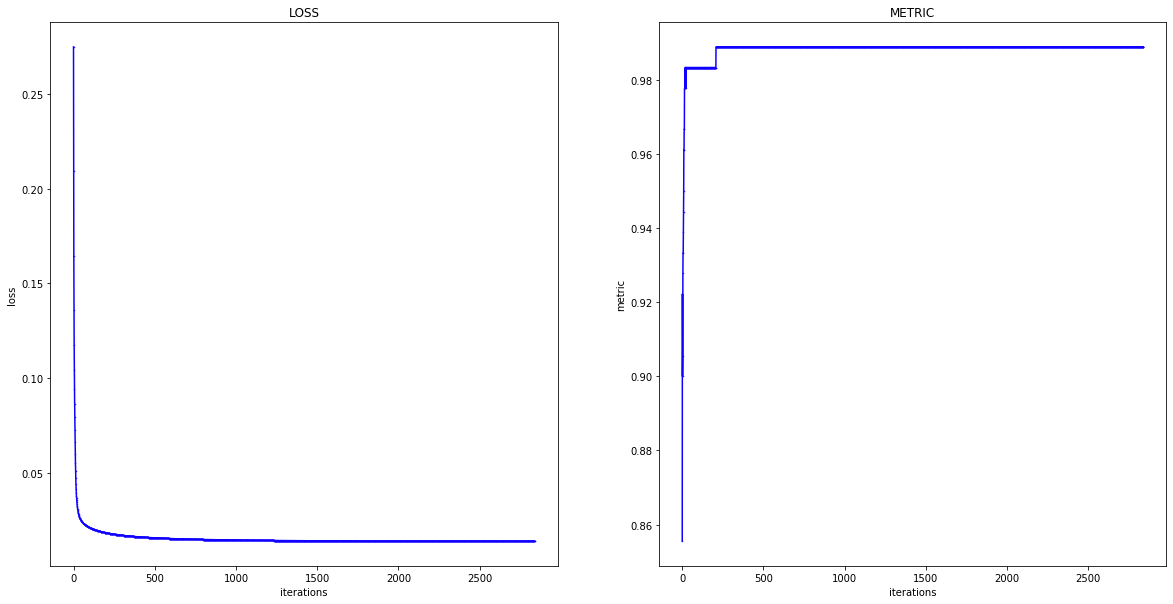

In [15]:
loss = lda.history['loss']
metric = lda.history['metric']

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title('LOSS')
ax1.set_xlabel('iterations')
ax1.set_ylabel('loss')
ax1.plot(loss, marker='.', color='#0F00FF', markersize=1, linestyle='-')
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title('METRIC')
ax2.set_xlabel('iterations')
ax2.set_ylabel('metric')
ax2.plot(metric, marker='.', color='#0F00FF', markersize=1, linestyle='-')